In [378]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn.functional as F
import tqdm
import random

from torch import nn
from einops import rearrange, repeat, pack, unpack
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

from vit_pytorch.vit import Transformer

In [379]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [380]:
ecg_mat = scipy.io.loadmat('ECGData.mat')

In [381]:
ecg_data = ecg_mat['ECGData'][0][0][0]
print(ecg_data.shape)

(162, 65536)


In [382]:
labels = ecg_mat['ECGData'][0][0][1]
print(labels.shape)

(162, 1)


In [383]:
def split_dataset_indices(N, train_percent, val_percent, test_percent, seed=42):
    # Validate input percentages
    if train_percent + val_percent + test_percent != 100:
        raise ValueError("The sum of the percentages must be 100.")

    random.seed(seed)
    # Generate a list of indices
    indices = list(range(N))
    random.shuffle(indices)

    # Calculate split sizes
    train_size = int((train_percent / 100) * N)
    val_size = int((val_percent / 100) * N)

    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    return train_indices, val_indices, test_indices

In [384]:
train_indices, val_indices, test_indices = split_dataset_indices(labels.shape[0], 70, 15, 15)

In [398]:
def create_windowed_dataset(data, labels, window_size=1024, stride=None):
    if not stride:
        stride = window_size

    min_val = np.min(data, axis=(0, 1), keepdims=True)
    max_val = np.max(data, axis=(0, 1), keepdims=True)
    data = 2 * ((data - min_val) / (max_val - min_val)) - 1
    
    num_samples, sample_size = data.shape
    num_windows = sample_size // window_size
    
    # Initialize the windowed data and label arrays
    windowed_data = np.empty((num_samples * num_windows, window_size))
    windowed_labels = np.empty((num_samples * num_windows, 1), dtype=labels.dtype)

    seqs = []
    for i in range(num_samples):
        for j in range(num_windows):
            start = j * stride
            end = start + window_size
            windowed_data[i * num_windows + j, :] = data[i, start:end]
            windowed_labels[i * num_windows + j, :] = labels[i]
        seqs.append(num_windows)
    seq_lens = np.array(seqs)

    labels_flattened = np.array([label[0][0] for label in windowed_labels])

    # Encode the string labels to integers
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels_flattened)

    return windowed_data, labels_encoded, seq_lens

In [400]:
WINDOW_SIZE = 64

In [386]:
ecg_t, labels_t, seq_t = create_windowed_dataset(ecg_data[train_indices], labels[train_indices], window_size=WINDOW_SIZE)
ecg_v, labels_v, seq_v = create_windowed_dataset(ecg_data[val_indices], labels[val_indices], window_size=WINDOW_SIZE)

In [387]:
ecg_t.shape

(231424, 32)

In [388]:
ecg_v.shape

(49152, 32)

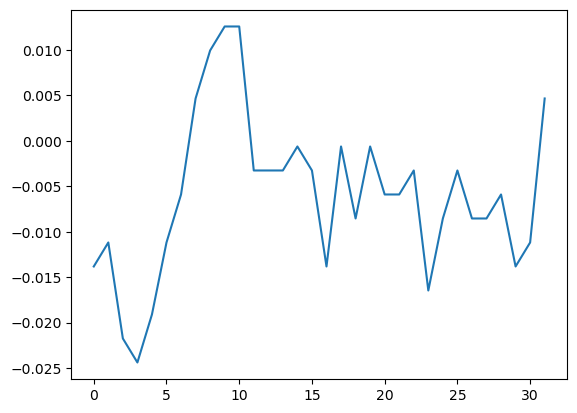

In [389]:
plt.plot(ecg_v[0, :])

In [394]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        def build_decoder(input_dim, latent_dim):
            model = Sequential()
        
            # Initial dense layer to upscale from latent_dim to a closer, but smaller power of 2
            initial_upscale_dim = 8  # This can be adjusted as needed
            model.add(layers.Dense(units=initial_upscale_dim, activation='relu', input_shape=(latent_dim,)))
            model.add(layers.Reshape((initial_upscale_dim, 1)))
        
            # Calculate how many times we need to double the size to get close to input_dim
            num_layers = int(np.log2(input_dim / initial_upscale_dim))
        
            filters = 64
            for i in range(num_layers):
                filters = max(filters // 2, 8)
                model.add(layers.Conv1DTranspose(filters=filters, kernel_size=3, strides=2, padding='same', activation='relu'))
        
            # If we're not yet at the input_dim, adjust with a dense layer
            model.add(layers.Flatten())
            model.add(layers.Dense(input_dim, activation='relu'))
            model.add(layers.Reshape((input_dim, 1)))
        
            return model
    
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Flatten(),
            layers.Dense(latent_dim)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Reshape((latent_dim, 1)),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(32, 3, strides=1, activation='relu', padding="same"), # 64
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(16, 3, strides=1, activation='relu', padding="same"), # 64
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

        self.encoder = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(input_dim),
        ])
        #self.decoder = build_decoder(input_dim, latent_dim)

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded

In [395]:
input_dim = ecg_t.shape[-1]

latent_dim = 16

model = AutoEncoder(input_dim, latent_dim)
model.build((None, input_dim))
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss="mae")
model.encoder.summary()
model.decoder.summary()
model.summary()

epochs = 100
batch_size = 64
early_stopping = EarlyStopping(patience=5, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)

history = model.fit(ecg_t, ecg_t, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], validation_data=(ecg_v, ecg_v))

Model: "sequential_186"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_321 (Dense)           (None, 64)                2112      
                                                                 
 dense_322 (Dense)           (None, 16)                1040      
                                                                 
Total params: 3152 (12.31 KB)
Trainable params: 3152 (12.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_187"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_323 (Dense)           (None, 64)                1088      
                                                                 
 dense_324 (Dense)           (None, 32)                2080      
                                                            

In [396]:
# loss: 0.0045 - val_loss: 0.0137

(1, 32)
(1, 16)
(1, 32)


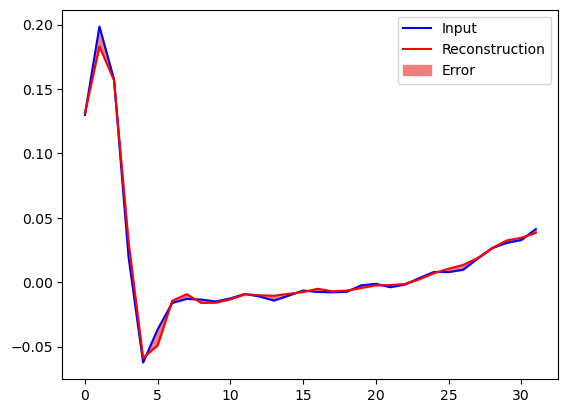

(1, 32)
(1, 16)
(1, 32)


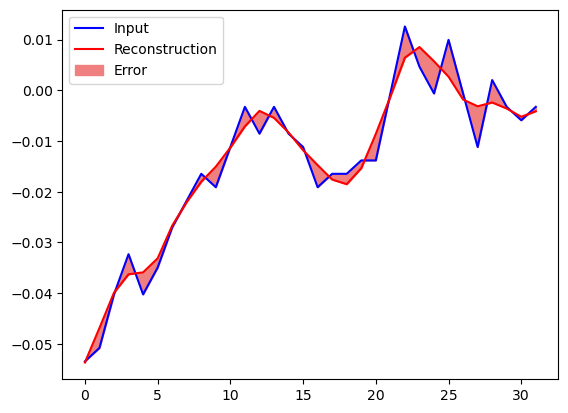

In [402]:
#Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
    sample = data[n:n+1]
    enc_img = model.encoder(sample)
    dec_img = model.decoder(enc_img)
    print(sample.shape)
    print(enc_img.shape)
    print(dec_img.shape)
    plt.plot(sample[0, :], 'b')
    plt.plot(dec_img[0, :], 'r')
    plt.fill_between(np.arange(WINDOW_SIZE), sample[0, :], dec_img[0, :], color = 'lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.show()

plot(ecg_t, 2)
plot(ecg_v, 2)

# Sequence modeling

Now, we'll create a "dataset" of embeddings for reconstruction. Now that we have a decoder that generally works OK, we'll embed each patch.

In [403]:
emb_t = model.encoder(ecg_t)
emb_v = model.encoder(ecg_v)

In [404]:
print(f'emb_t: {emb_t.shape}')
print(f'emb_v: {emb_v.shape}')

emb_t: (231424, 16)
emb_v: (49152, 16)


In [405]:
def generate_sequences(embeddings, sequence_lengths, window_size=10):
    features, labels = [], []

    start_idx = 0
    for length in sequence_lengths:
        for i in range(start_idx, start_idx + length - window_size):
            features.append(embeddings[i:i + window_size])
            labels.append(embeddings[i + window_size])
        start_idx += length

    return np.array(features), np.array(labels)

In [406]:
seq_xt, seq_yt = generate_sequences(emb_t, seq_t, window_size=10)
seq_xv, seq_yv = generate_sequences(emb_v, seq_v, window_size=10)

In [407]:
seq_xt.shape

(230294, 10, 16)

In [408]:
seq_yt.shape

(230294, 16)

In [409]:
input_shape = tuple([None] + list(seq_xt.shape[1:]))

In [471]:
seqmodel_inputs = layers.Input(input_shape[1:])

x = seqmodel_inputs

def transformer_layer(x):
    x1 = layers.LayerNormalization()(x)
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=2)(x1, x1)
    x2 = layers.Add()([attention_output, x])
    x3 = layers.LayerNormalization()(x2)
    x3 = layers.Dense(256, activation='relu')(x3)
    x3 = layers.Dense(16, activation='relu')(x3)
    x = layers.Add()([x3, x2])
    return x

x = transformer_layer(x)
x = layers.LayerNormalization()(x)

x = transformer_layer(x)
x = layers.LayerNormalization()(x)

# decoder
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(latent_dim)(x)
seqmodel_outputs = x

seqmodel = Model(seqmodel_inputs, seqmodel_outputs, name="mae_encoder")

seqmodel.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss="mae")
seqmodel.build(input_shape=input_shape)
seqmodel.summary()

Model: "mae_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_47 (InputLayer)       [(None, 10, 16)]             0         []                            
                                                                                                  
 layer_normalization_34 (La  (None, 10, 16)               32        ['input_47[0][0]']            
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_13 (M  (None, 10, 16)               552       ['layer_normalization_34[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalizatio

In [473]:
epochs = 100
batch_size = 64
early_stopping = EarlyStopping(patience=20, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)

history = seqmodel.fit(seq_xt, seq_yt, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], validation_data=(seq_xv, seq_yv))

Epoch 1/100
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0234 - val_loss: 0.0578
Epoch 2/100
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0232 - val_loss: 0.0573
Epoch 3/100
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0230 - val_loss: 0.0573
Epoch 4/100
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0228 - val_loss: 0.0574
Epoch 5/100
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0227 - val_loss: 0.0576
Epoch 6/100
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0226 - val_loss: 0.0574
Epoch 7/100
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0224 - val_loss: 0.0582
Epoch 8/100
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0223 - val_loss: 0.0575
Epoch 9/100
3599/3599 [==============================] - 15s 4ms/step - loss: 0.0222 - val_loss: 0.0588
Epoch 10/100
3599/3599 [==============================] - 15s 4m

In [447]:
'''
x = seqmodel_inputs
x1 = layers.LayerNormalization()(x)

attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=2)(x1, x1)
x2 = layers.Add()([attention_output, x])
x3 = layers.LayerNormalization()(x2)
x3 = layers.Dense(256, activation='relu')(x3)
x3 = layers.Dense(16, activation='relu')(x3)
x = layers.Add()([x3, x2])
x = layers.LayerNormalization()(x)

# decoder
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(latent_dim)(x)
seqmodel_outputs = x

seqmodel = Model(seqmodel_inputs, seqmodel_outputs, name="mae_encoder")

'''

# loss: 1.1785 - val_loss: 3.4536
# for 32 window: loss: 0.0314 - val_loss: 0.0739
# transformer lite: loss: 0.0228 - val_loss: 0.0575

"\nlayers.LSTM(480),\nlayers.BatchNormalization(),\nlayers.Dense(128, activation='relu'),\nlayers.BatchNormalization(),\nlayers.Dense(48)\n"

In [474]:
seq_yt_pred = seqmodel(seq_xt)
seq_yv_pred = seqmodel(seq_xv)
seq_yv_pred.shape

TensorShape([48912, 16])

In [475]:
def plot_sample(model, actual_emb, pred_emb):
    actual = model.decoder(np.expand_dims(actual_emb, 0))[0]
    pred = model.decoder(np.expand_dims(pred_emb, 0))[0]
    print(actual.shape)
    print(pred.shape)
    plt.plot(actual, 'b')
    plt.plot(pred, 'r')
    plt.fill_between(np.arange(WINDOW_SIZE), actual, pred, color = 'lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.show()

(32,)
(32,)


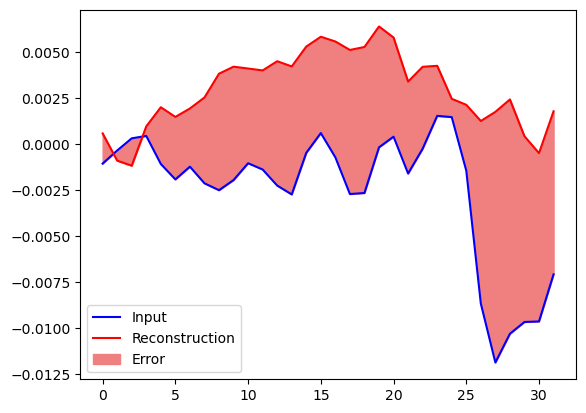

In [503]:
idx = 2608
plot_sample(model, seq_yt[idx], seq_yt_pred[idx])

(32,)
(32,)


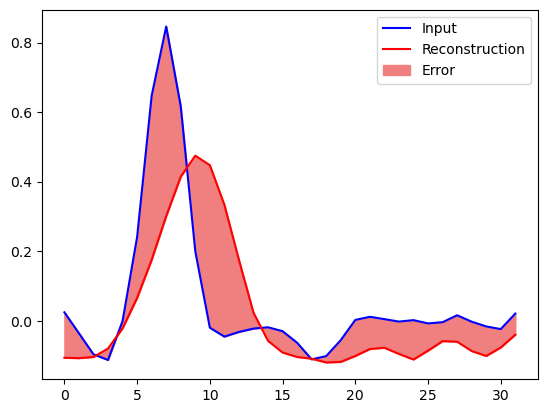

In [524]:
idx = 1270
plot_sample(model, seq_yv[idx], seq_yv_pred[idx])

# Combined approach

Use the encoder and decoder architectures to patch and predict based on the raw data

In [598]:
class CombinedModel(Model):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder_layers = [
            layers.Dense(64, activation='relu'),
            layers.Dense(self.latent_dim)
        ]
        self.decoder_layers = [
            layers.Dense(64, activation='relu'),
            layers.Dense(self.input_dim)
        ]

        self.layer_norm1 = layers.LayerNormalization()
        self.attn = layers.MultiHeadAttention(num_heads=4, key_dim=2)
        self.add1 = layers.Add()
        self.layer_norm2 = layers.LayerNormalization()
        self.transformer_dense1 = layers.Dense(256, activation='relu')
        self.transformer_dense2 = layers.Dense(16, activation='relu')
        self.add2 = layers.Add()

        self.transformer_flatten = layers.Flatten()
        self.transformer_decoder1 = layers.Dense(256, activation='relu')
        self.transformer_decoder2 = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.patch_encoder(inputs) # (seq_len, patch_size) -> (seq_len, latent_dim)
        x = self.transformer(x) # (seq_len, latent_dim) -> (latent_dim)
        x = self.patch_decoder(x) # (latent_dim) -> (patch_size)
        return x
        
    def patch_encoder(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        return x

    def patch_decoder(self, x):
        for layer in self.decoder_layers:
            x = layer(x)
        return x

    def transformer(self, x):
        x1 = self.layer_norm1(x)
        attention_output = self.attn(x1, x1)
        x2 = self.add1([attention_output, x])
        x3 = self.layer_norm2(x2)
        x3 = self.transformer_dense1(x3)
        x3 = self.transformer_dense2(x3)
        x = self.add2([x3, x2])
        x = self.transformer_flatten(x)
        x = self.transformer_decoder1(x)
        x = self.transformer_decoder2(x)
        return x

In [599]:
combined = CombinedModel(WINDOW_SIZE, latent_dim)

In [600]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=1e-3#, decay=WEIGHT_DECAY
)

# Compile and pretrain the model.
combined.compile(
    optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=["mae"]
)

In [601]:
ecg_tx_seq, ecg_ty_seq = generate_sequences(ecg_t, seq_t, window_size=10)
ecg_vx_seq, ecg_vy_seq = generate_sequences(ecg_v, seq_v, window_size=10)

In [602]:
history = combined.fit(
    ecg_tx_seq, ecg_ty_seq,
    shuffle=True,
    epochs=10,
    validation_data=(ecg_vx_seq, ecg_vy_seq)
)

Epoch 1/10
7197/7197 [==============================] - 15s 2ms/step - loss: 0.0019 - mae: 0.0237 - val_loss: 0.0091 - val_mae: 0.0510
Epoch 2/10
7197/7197 [==============================] - 15s 2ms/step - loss: 0.0015 - mae: 0.0210 - val_loss: 0.0074 - val_mae: 0.0445
Epoch 3/10
7197/7197 [==============================] - 14s 2ms/step - loss: 0.0013 - mae: 0.0197 - val_loss: 0.0069 - val_mae: 0.0429
Epoch 4/10
7197/7197 [==============================] - 14s 2ms/step - loss: 0.0012 - mae: 0.0189 - val_loss: 0.0071 - val_mae: 0.0435
Epoch 5/10
7197/7197 [==============================] - 14s 2ms/step - loss: 0.0012 - mae: 0.0182 - val_loss: 0.0064 - val_mae: 0.0420
Epoch 6/10
7197/7197 [==============================] - 15s 2ms/step - loss: 0.0011 - mae: 0.0178 - val_loss: 0.0067 - val_mae: 0.0439
Epoch 7/10
7197/7197 [==============================] - 15s 2ms/step - loss: 0.0011 - mae: 0.0175 - val_loss: 0.0065 - val_mae: 0.0424
Epoch 8/10
7197/7197 [==============================] -

In [663]:
ecg_vy_seq_pred = combined(ecg_vx_seq)
ecg_ty_seq_pred = combined(ecg_tx_seq)

In [643]:
def plot_sample2(actual, pred):
    plt.plot(actual, 'b')
    plt.plot(pred, 'r')
    plt.fill_between(np.arange(WINDOW_SIZE), actual, pred, color = 'lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.show()

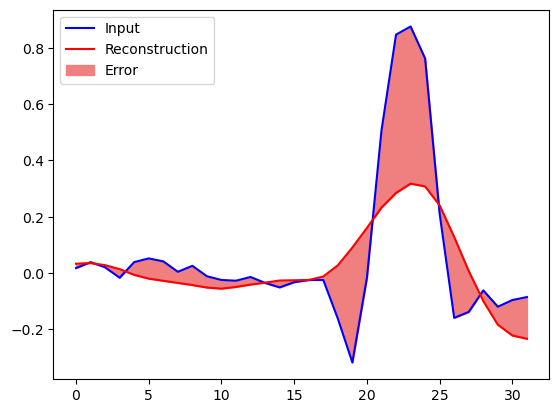

In [644]:
idx = 1917
plot_sample2(ecg_vy_seq[idx], ecg_vy_seq_pred[idx])

In [661]:
def plot_sequence(actuals, preds, start, stop):
    print(actuals.shape)
    actual = np.concatenate(actuals[start:stop])
    print(actual.shape)
    pred = np.concatenate(preds[start:stop])
    print(pred.shape)
    plt.plot(actual, 'b')
    plt.plot(pred, 'r')
    plt.fill_between(np.arange((stop-start) * len(actuals[0])), actual, pred, color = 'lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.show()

(48912, 32)
(800,)
(800,)


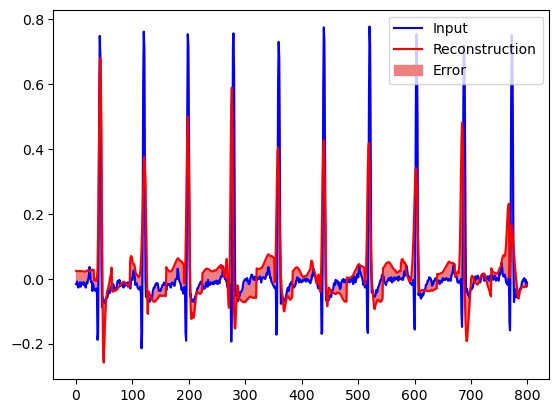

In [662]:
plot_sequence(ecg_vy_seq, ecg_vy_seq_pred, 50, 75)

(230294, 32)
(2400,)
(2400,)


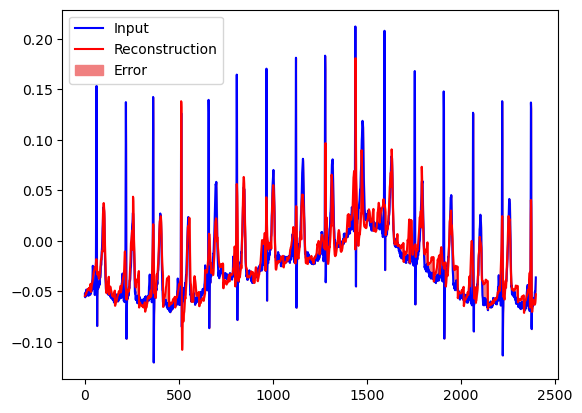

In [665]:
plot_sequence(ecg_ty_seq, ecg_ty_seq_pred, 100, 175)